# Burnt area mapping using Sentinel-2 data  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook compatible with the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.dea.ga.gov.au/ga_s2bm_ard_3)

## Background

### Normalized Burn Ratio

The Normalized Burn Ratio (NBR) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. 
It is calculated using the following Sentinel-2 bands: Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. 
**Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value**. 
Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ratio - also called Delta Normalized Burn Ratio (dNBR) - is calculated by subtracting the post-fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what is burnt as it shows change from the baseline state. 
**A burnt area will have a positive dNBR value** while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity). 
A higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burnt from unburnt areas when using Sentinel-2. 
However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

In the example presented in this notebook, which covers part of the Clyde Mountain fire in the area north of Batemans Bay, the fire occurred in heavily forested area, which returns a very strong dNBR result. 
Using +0.1 as a threshold here results in many false positives being picked up in the unburnt urban and forest areas where vegetation drying has occurred prior to the fire. 
A much more conservative threshold here of +0.3 produces a better result. 
Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interpreting results as a number of possible false positives can return a positive dNBR result:

* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out of bright green vegetation such as grasses. 
If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burnt area extent. 
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. 
The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. 
The code in this notebook will automatically generate the composite image over the set length of time using Sentinel-2 data..

The notebook contains the following steps:

1.  Select a location for the analysis
2.  Define fire event date and length of composite image
3.  Load all baseline data
4.  Generate Normalized Burn Ratio for baseline period
5.  Load post-fire data
6.  Generate Normalized Burn Ratio for post fire image
7.  Calculate Delta Normalized Burn Ratio
8.  Apply threshold to Delta Normalized Burn Ratio
9.  Calculate the area burnt
10. Export results as a GeoTIFF

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:35153' processes=1 threads=2, memory=12.21 GiB>

2024-10-08 22:18:14,079 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'dataset-4bfb1099d9844fc8a42436661845686e' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f547d518a60>, (Dataset <id=4bfb1099-d984-4fc8-a424-36661845686e product=ga_s2bm_ard_3 location=s3://dea-public-data/baseline/ga_s2bm_ard_3/56/JNP/2018/12/21/20181221T012304/ga_s2bm_ard_3-2-1_56JNP_2018-12-21_final.stac-item.json>,), {})
new run_spec: (<function execute_task at 0x7f547d518a60>, (Dataset <id=4bfb1099-d984-4fc8-a424-36661845686e product=ga_s2bm_ard_3 location=s3://dea-public-data/baseline/ga_s2b

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="3001 BA Mapping Project")

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
#lamington national park (north)
central_lat = -28.208668
central_lon = 153.137569

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

#### Define dates on which images will be captured from

In [54]:
# Fire event date
fire_date18 = '2018-12-21'
fire_date19 = '2019-12-06'
fire_date20_1 = '2020-03-20'
fire_date20_2 = '2020-06-24'
fire_date20_3 = '2020-09-26'
fire_date20 = '2020-12-01'
fire_date21 = '2021-12-15'
fire_date22 = '2022-11-15'
fire_date23 = '2023-12-06'

#### Define load parameters

In [5]:
resolution = (-20, 20)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir_1', 'nbart_swir_3']
min_gooddata = 0.8
output_crs = 'EPSG:3113'#'EPSG:3857'

## Load 2018 pre-fire data and 2019 post fire data

In [6]:
# Load all data in baseline period available from ARD data
baseline = load_ard(dc=dc,
                        products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                        x=study_area_lon,
                        y=study_area_lat,
                        time=(fire_date18, fire_date18),
                        measurements=measurements,
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [7]:
# Load post-fire data from Sentinel-2A and 2B, 2019 Dec
post19 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date19, fire_date19),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [21]:
print("\n")
post20_1 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date20_1, fire_date20_1),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [34]:
print("\n")
post20_2 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date20_2, fire_date20_2),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [48]:
print("\n")
post20_3 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date20_3, fire_date20_3),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [8]:
print("\n")
post20 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date20, fire_date20),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [9]:
print("\n")
post21 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date21, fire_date21),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [55]:
print("\n")
post22 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date22, fire_date22),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


In [10]:
print("\n")
post23 = load_ard(dc=dc,
           products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
           x=study_area_lon,
           y=study_area_lat,
           time=(fire_date23, fire_date23),
           min_gooddata=min_gooddata,
           measurements=measurements,
           output_crs=output_crs,
           resolution=resolution,
           group_by='solar_day')



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 1 out of 1 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1 time steps


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Generate Normalized Burn Ratio for baseline period

In [56]:
# Calculate NBR for the baseline images 2018
baseline = calculate_indices(baseline, index='NBR', collection='ga_s2_3', drop=False)
# Compute median using all observations in the dataset along the time axis
baseline_image = baseline.median(dim='time')
# Select NBR
baseline_NBR = baseline_image.NBR

# Calculate NBR for post fire data image

# 2019 image
post_image19 = post19.isel(time=0)
post_image19 = calculate_indices(post_image19, index='NBR', collection='ga_s2_3', drop=False)
post_NBR19 = post_image19.NBR

# 2020 March
post_image20_1 = post20_1.isel(time=0)
post_image20_1 = calculate_indices(post_image20_1, index='NBR', collection='ga_s2_3', drop=False)
post_NBR20_1 = post_image20_1.NBR

# 2020 June
post_image20_2 = post20_2.isel(time=0)
post_image20_2 = calculate_indices(post_image20_2, index='NBR', collection='ga_s2_3', drop=False)
post_NBR20_2 = post_image20_2.NBR

# 2020 Sep
post_image20_3 = post20_3.isel(time=0)
post_image20_3 = calculate_indices(post_image20_3, index='NBR', collection='ga_s2_3', drop=False)
post_NBR20_3 = post_image20_3.NBR

# 2020 December
post_image20 = post20.isel(time=0)
post_image20 = calculate_indices(post_image20, index='NBR', collection='ga_s2_3', drop=False)
post_NBR20 = post_image20.NBR

# 2021
post_image21 = post21.isel(time=0)
post_image21 = calculate_indices(post_image21, index='NBR', collection='ga_s2_3', drop=False)
post_NBR21 = post_image21.NBR

# 2022
post_image22 = post22.isel(time=0)
post_image22 = calculate_indices(post_image22, index='NBR', collection='ga_s2_3', drop=False)
post_NBR22 = post_image21.NBR

#2023
post_image23 = post23.isel(time=0)
post_image23 = calculate_indices(post_image23, index='NBR', collection='ga_s2_3', drop=False)
post_NBR23 = post_image23.NBR

Plot the baseline NBR data side-by-side with an RGB plot of the study area:

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


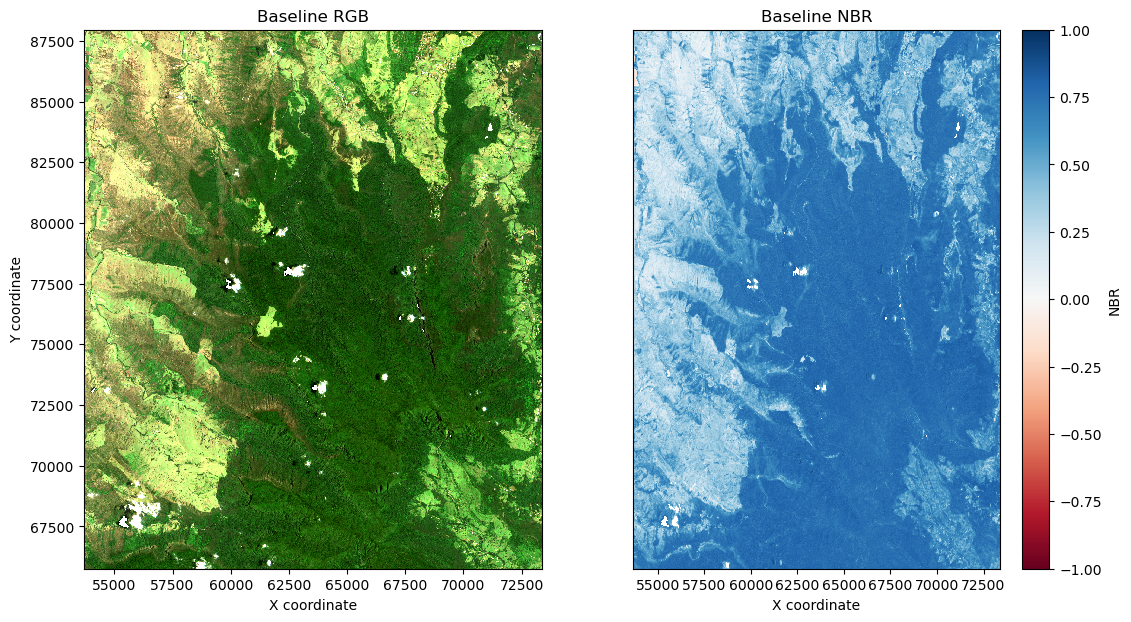

In [57]:
# Set up subplots for 2018
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(baseline_image, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

# Set up subplots for 2019

# Optional to plot others 20,21,23

## Calculate dNBR for the first time period (2018 - 2019)
We can now compute delta NBR by subtracting our post-fire NBR data from our baseline NBR data:

In [58]:
delta_NBR19 = baseline_NBR - post_NBR19

# Visualise dNBR image
#delta_NBR19.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
#plt.xlabel('X coordinate')
#plt.ylabel('Y coordinate');

# 2020 March
delta_NBR20_1 = baseline_NBR - post_NBR20_1

# 2020 June
delta_NBR20_2= baseline_NBR - post_NBR20_2

# 2020 Sep
delta_NBR20_3= baseline_NBR - post_NBR20_3

# 2020 Dec
delta_NBR20 = baseline_NBR - post_NBR20

# 2021 Dec
delta_NBR21 = baseline_NBR - post_NBR21

# 2022 Nov
delta_NBR22 = baseline_NBR - post_NBR22

# 2023 Dec
delta_NBR23 = baseline_NBR - post_NBR23

## Apply threshold to Delta Normalized Burn Ratio

Set and apply the NBR threshold.
Here we set it to 0.3, but this will need adjustment depending on the use case.  

In [59]:
# Set threshold for 2018 - 2019 date range
threshold = 0.50

# Apply threshold
burnt19 = delta_NBR19 > threshold
# Mask post-fire true colour image
masked19 = delta_NBR19.where(burnt19==1)

burnt20_1 = delta_NBR20_1 > threshold
masked20_1 = delta_NBR20_1.where(burnt20_1==1)

burnt20_2 = delta_NBR20_2 > threshold
masked20_2 = delta_NBR20_2.where(burnt20_2==1)

burnt20_3 = delta_NBR20_3 > threshold
masked20_3 = delta_NBR20_3.where(burnt20_3==1)

burnt20 = delta_NBR20 > threshold
masked20 = delta_NBR20.where(burnt20==1)

burnt21 = delta_NBR21 > threshold
masked21 = delta_NBR21.where(burnt21==1)

burnt22 = delta_NBR22 > threshold
masked22 = delta_NBR22.where(burnt22==1)

burnt23 = delta_NBR23 > threshold
masked23 = delta_NBR23.where(burnt23==1)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


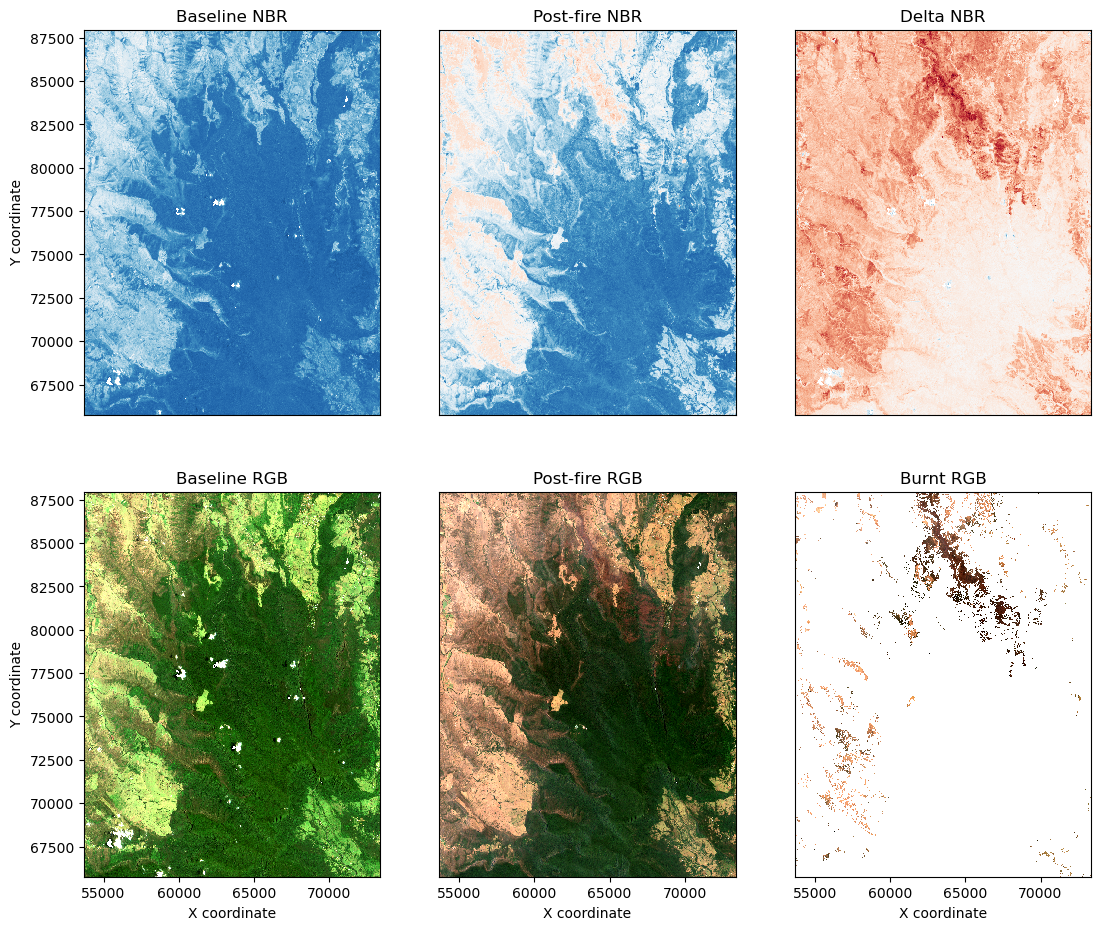

In [15]:
# Set up subplots for 2018-2019 date range
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

#Baseline NBR - 2018
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

#Post fire NBR - 2019
post_NBR19.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

#dNBR 2018-2019
delta_NBR19.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

#RGB Baseline Image 2018
rgb(baseline_image, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

#RGB Post image 2019
rgb(post_image19, bands=bands, ax=axarr[1,1])
axarr[1, 1].set_title('Post-fire RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

#Post image burnt mask
rgb(post_image19.where(burnt19==1), bands=bands, ax=axarr[1, 2])
axarr[1, 2].set_title('Burnt RGB')
axarr[1, 2].set_xlabel('X coordinate')
axarr[1, 2].yaxis.set_visible(False)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


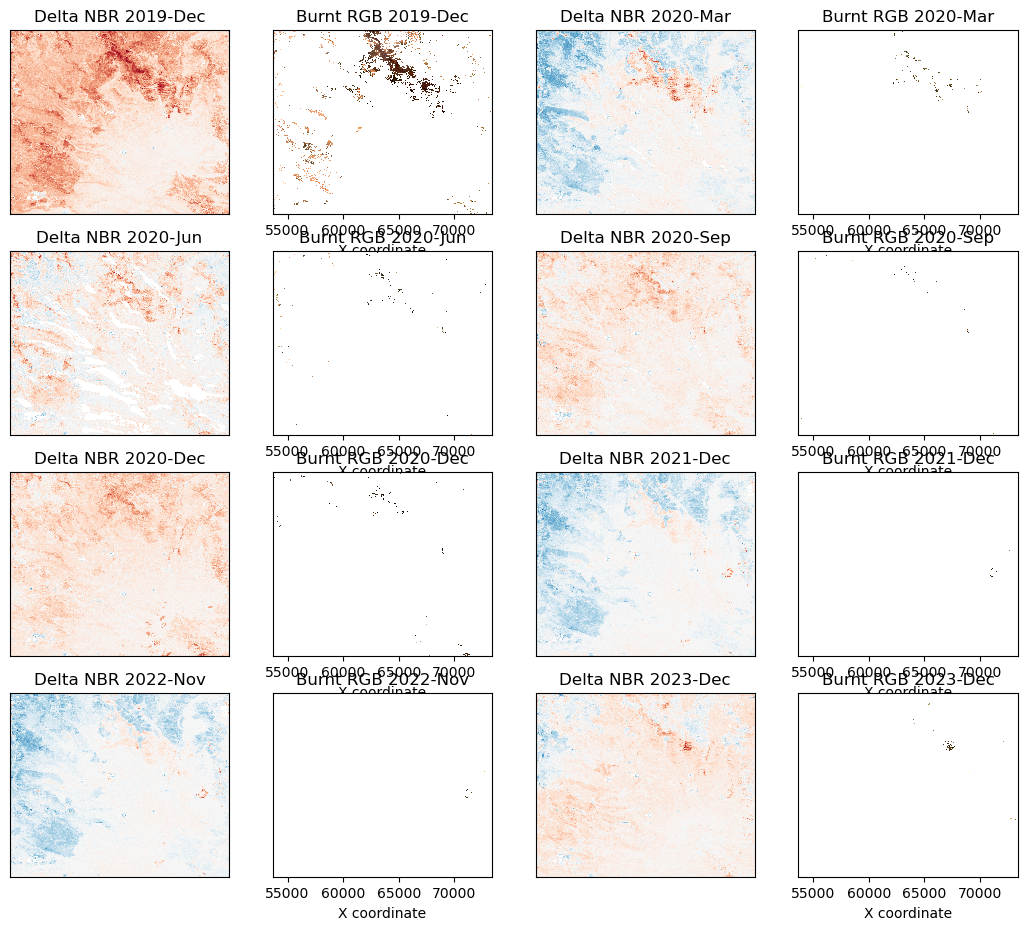

In [60]:
# Comparison Plot for Time series

# Set up subplots
f, axarr = plt.subplots(4, 4, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

#dNBR 2019
delta_NBR19.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Delta NBR 2019-Dec')
axarr[0, 0].yaxis.set_visible(False)
axarr[0, 0].xaxis.set_visible(False)

rgb(post_image19.where(burnt19==1), bands=bands, ax=axarr[0, 1])
axarr[0, 1].set_title('Burnt RGB 2019-Dec')
axarr[0, 1].set_xlabel('X coordinate')
axarr[0, 1].yaxis.set_visible(False)

#dNBR 2020 Mar
delta_NBR20_1.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR 2020-Mar')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(post_image20_1.where(burnt20_1==1), bands=bands, ax=axarr[0, 3])
axarr[0, 3].set_title('Burnt RGB 2020-Mar')
axarr[0, 3].set_xlabel('X coordinate')
axarr[0, 3].yaxis.set_visible(False)

#dNBR 2020 Jun
delta_NBR20_2.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 0])
axarr[1, 0].set_title('Delta NBR 2020-Jun')
axarr[1, 0].yaxis.set_visible(False)
axarr[1, 0].xaxis.set_visible(False)

rgb(post_image20_2.where(burnt20_2==1), bands=bands, ax=axarr[1, 1])
axarr[1, 1].set_title('Burnt RGB 2020-Jun')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

#dNBR 2020 Sep
delta_NBR20_3.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 2])
axarr[1, 2].set_title('Delta NBR 2020-Sep')
axarr[1, 2].yaxis.set_visible(False)
axarr[1, 2].xaxis.set_visible(False)

#Post image burnt RGB mask 
rgb(post_image20_3.where(burnt20_3==1), bands=bands, ax=axarr[1, 3])
axarr[1, 3].set_title('Burnt RGB 2020-Sep')
axarr[1, 3].set_xlabel('X coordinate')
axarr[1, 3].yaxis.set_visible(False)

#dNBR 2020 Dec
delta_NBR20.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[2, 0])
axarr[2, 0].set_title('Delta NBR 2020-Dec')
axarr[2, 0].yaxis.set_visible(False)
axarr[2, 0].xaxis.set_visible(False)

#Post image burnt RGB mask 
rgb(post_image20.where(burnt20==1), bands=bands, ax=axarr[2, 1])
axarr[2, 1].set_title('Burnt RGB 2020-Dec')
axarr[2, 1].set_xlabel('X coordinate')
axarr[2, 1].yaxis.set_visible(False)

#dNBR 2021
delta_NBR21.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[2, 2])
axarr[2, 2].set_title('Delta NBR 2021-Dec')
axarr[2, 2].yaxis.set_visible(False)
axarr[2, 2].xaxis.set_visible(False)

rgb(post_image21.where(burnt21==1), bands=bands, ax=axarr[2, 3])
axarr[2, 3].set_title('Burnt RGB 2021-Dec')
axarr[2, 3].set_xlabel('X coordinate')
axarr[2, 3].yaxis.set_visible(False)

#dNBR 2022
delta_NBR22.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[3, 0])
axarr[3, 0].set_title('Delta NBR 2022-Nov')
axarr[3, 0].yaxis.set_visible(False)
axarr[3, 0].xaxis.set_visible(False)

rgb(post_image22.where(burnt22==1), bands=bands, ax=axarr[3, 1])
axarr[3, 1].set_title('Burnt RGB 2022-Nov')
axarr[3, 1].set_xlabel('X coordinate')
axarr[3, 1].yaxis.set_visible(False)

#dNBR 2023
delta_NBR23.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[3, 2])
axarr[3, 2].set_title('Delta NBR 2023-Dec')
axarr[3, 2].yaxis.set_visible(False)
axarr[3, 2].xaxis.set_visible(False)

#Post image burnt RGB mask 
rgb(post_image23.where(burnt23==1), bands=bands, ax=axarr[3, 3])
axarr[3, 3].set_title('Burnt RGB 2023-Dec')
axarr[3, 3].set_xlabel('X coordinate')
axarr[3, 3].yaxis.set_visible(False)

In [18]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
burnt_area = burnt.sum() * area_per_pixel
burnt_area_hec = burnt.sum() * area_per_pixel * 100
burnt_area_per = burnt_area / unburnt_area  * 100
not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
nan_area = delta_NBR.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area_hec.item():.2f} hectares')
print(f'Burnt area:              {burnt_area_per.item():.2f} %')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

NameError: name 'delta_NBR' is not defined

In [ ]:
# Define an area name to be used in saved file names
area_name = 'Example'

# Write baseline reference image to multi-band GeoTIFF
cog.write_cog(baseline_image.NBR, f'{area_name}_baseline_image.tif', overwrite=True)

# Write post fire image to multi-band GeoTIFF
cog.write_cog(post_image.NBR, f'{area_name}_post_fire_image.tif', overwrite=True)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
cog.write_cog(delta_NBR, f'{area_name}_delta_NBR.tif', overwrite=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->